<a href="https://colab.research.google.com/github/deejay14/Jhakas-NewsWala/blob/main/Text_anlysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
 pip install dateparser

     |████████████████████████████████| 286kB 8.6MB/s 


In [ ]:
df = pd.read_csv("MS17142_scrapped .csv") 

In [ ]:
df

,Unnamed: 0,Title,News article
0,0,"67% Of India's Active Covid Cases In Kerala, ...","In past week, India has not recorded any Covid..."
1,1,Links Showing Another Woman As Hathras Victim...,"Social media platforms Facebook, Google and Tw..."
2,2,"India Beat All Odds In Coronavirus Fight, Say...",PM Modi said India launched the world's bigges...
3,3,"PM Modi To Girl Cadets At NCC Event: ""Nation ...",PM Modi felicitates NCC Cadets at Cariappa Gro...
4,4,Top Quotes Of PM Modi's Address At World Econ...,PM Modi spoke on India's economic growth traje...
...,...,...,...
2309,2309,Is asteroid Apophis capable of triggering a ts...,It was around a few months back that Iain McDo...
2310,2310,New 'dengue-like disease' spreading among chil...,The number of children affected by a new disea...
2311,2311,"GameStop shares surge 1,700% in 2 weeks, Nasda...",As the unusual market surge of Gamestop shares...
2312,2312,"Over 4000 deaths in a single day, US chocks as...",It was during the summer peak of the coronavir...


In [ ]:
data_list = df['News article'].values.tolist()

In [ ]:
import re
from pprint import pprint
import nltk, spacy, gensim
from sklearn.feature_extraction.text import CountVectorizer

def get_lemmatized_clean_data(df):
    # Convert to list
    data = df['News article'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    pprint(data[:1])

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(data))

    print(data_words[:1])
    
    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
        return texts_out

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # Run in terminal: python3 -m spacy download en
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    # Do lemmatization keeping only Noun, Adj, Verb, Adverb
    data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    return data_lemmatized

In [ ]:
data_lemmatized = get_lemmatized_clean_data(df)

['In past week, India has not recorded any Covid case in a fifth of its '
 'districts: Health Ministry (File) On a day when the centre declared that '
 'India has flattened its COVID-19 graph after the first wave of infections '
 'peaked in September, it flagged concern about two states -- Kerala and '
 'Maharashtra. In India, Kerala has the highest number of active cases '
 'accounting for about 42 per cent of the overall 1.7 lakh active caseload. It '
 'is followed by Maharashtra. "The two states still have 40,000 or more active '
 'cases - Kerala with 72,000 cases and Maharashtra with 44,000 cases... '
 'Together, these states also account for 67 per cent of all (active) cases," '
 'Union Health Secretary Rajesh Bhushan said. Active case count, reflecting '
 'those still recovering from COVID-19, is used as a measure to check the '
 'spread of a disease. In the past one week, India has not recorded a single '
 'coronavirus case in a fifth of its districts as its immunisation program

In [ ]:
data_lemmatized

['past week record covid case fifth district file day when centre declare flatten covid graph first wave infection peak flag concern state high number active case account about cent overall active caseload follow state still more active case case maharashtra case together state also account cent active say active case count reflect still recover use measure check spread disease past week record single case fifth district immunisation programme cover people vaccine covaxin covishield country battle vaccine number global vaccination rank health ministry say quote present world datum datum show country vaccinate day vaccinate just day say add state vaccinate more cent total healthcare worker state vaccinate cent healthcare worker say list state where immunisation target remain cent currently vaccinate people day government plan vaccinate people person need dose mean vaccinate nearly people daily right now say add government engage private player ensure vaccine coverage entire population g

In [ ]:
len(data_lemmatized)

2314

In [ ]:

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [ ]:
data_vectorized

<2314x3693 sparse matrix of type '<class 'numpy.int64'>'
	with 228145 stored elements in Compressed Sparse Row format>

In [ ]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=50,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit(data_vectorized)

print(lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=50,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [ ]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data_lemmatized))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.150000,0.000000,0.180000,0.000000,0.030000,0.000000,0.630000,0.000000,0.000000,7
Doc1,0.020000,0.130000,0.000000,0.000000,0.000000,0.000000,0.840000,0.000000,0.000000,0.000000,6
Doc2,0.140000,0.590000,0.000000,0.220000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,1
Doc3,0.140000,0.590000,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000,0.000000,0.150000,1
Doc4,0.400000,0.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Doc5,0.250000,0.630000,0.000000,0.000000,0.000000,0.060000,0.040000,0.000000,0.000000,0.000000,1
Doc6,0.000000,0.480000,0.000000,0.000000,0.000000,0.000000,0.390000,0.000000,0.000000,0.120000,1
Doc7,0.000000,0.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.860000,9
Doc8,0.000000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,1
Doc9,0.000000,0.560000,0.000000,0.000000,0.000000,0.000000,0.130000,0.000000,0.310000,0.000000,1


In [ ]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,aap,abandon,ability,able,abroad,abrupt,absence,absolute,absolutely,absorb,abundance,abundant,abuse,academic,accelerate,accept,acceptable,access,accessible,accident,accidentally,accompany,accord,account,accumulate,accuracy,accurate,accuse,achieve,achievement,acid,acknowledge,acquire,acquit,acre,act,action,activate,activation,active,...,wise,wish,withdraw,withdrawal,witness,woman,wonder,wonderful,word,work,worker,working,world,worldwide,worried,worry,worsen,worship,worst,worth,wound,wrap,wrath,wreak,write,writer,wrong,yash,year,yellow,yesterday,yield,yoga,young,youngster,youth,youtube,zip,zone,zoom
Topic0,0.100002,0.100007,14.716496,42.239266,0.100058,0.100007,0.100025,0.100013,0.100038,0.100053,0.100010,0.100055,0.100009,1.432367,0.100053,0.100018,0.100006,44.696601,0.100100,0.100007,0.100028,0.100030,120.804034,0.100080,0.100025,7.277211,0.100036,0.100006,70.917221,7.393164,0.100008,4.592394,0.100073,0.100000,0.100034,11.199355,0.100054,0.100040,0.100019,0.100022,...,0.100006,8.702723,0.100018,0.100014,0.100031,1.336021,0.100035,5.921617,0.100018,237.191836,0.100020,14.466905,263.575138,0.100059,0.100039,0.100050,0.100016,0.100005,0.100024,0.100040,0.100003,0.100151,0.100001,0.100083,5.744404,0.100021,0.100069,0.100000,207.260094,0.100008,0.100026,0.100044,0.100003,0.100181,0.100055,0.100013,0.100038,0.100006,0.100027,0.100028
Topic1,12.048829,8.825895,5.041757,43.205157,12.802073,0.100007,3.117255,8.907000,9.617829,0.100009,0.100015,0.100013,0.100017,0.100244,4.922785,23.889525,8.255226,6.662327,0.100016,0.100021,8.815319,8.145886,56.875120,20.393802,3.256972,0.100007,0.100011,54.634322,10.908296,15.109314,0.100003,23.302537,8.870189,0.100017,19.467798,53.624547,148.693211,0.100003,1.152977,12.590375,...,1.448938,45.001769,51.340417,24.209549,9.702375,2.057247,19.454614,16.961886,20.427606,217.485479,106.833126,9.170434,160.012569,9.422518,3.830327,26.006785,19.098603,5.085224,4.218365,67.452866,0.102209,0.103170,0.100008,0.100021,47.660765,16.990958,18.524019,0.100003,882.179431,0.100014,15.028328,5.885269,0.100017,72.290334,12.457587,27.218955,0.100007,0.100009,6.868926,0.100059
Topic2,0.100000,0.100059,11.719489,87.526836,0.100004,0.100009,11.952513,7.668309,5.458740,22.441491,10.313557,10.658672,0.100001,2.436268,14.400208,7.249474,0.100000,0.100015,5.430857,0.100036,0.100054,2.682857,181.672131,15.350958,8.043947,6.430156,15.583882,0.100001,0.623633,0.100017,2.455255,0.100058,13.768630,0.100000,0.100031,2.053823,0.100186,2.934493,0.946341,17.416648,...,5.806356,0.100031,0.100002,0.100010,25.324721,0.100008,10.845506,0.100045,8.785559,53.832614,0.100005,0.100044,138.651519,6.291634,0.100022,0.100133,0.100048,0.100010,0.100001,2.673526,0.100008,4.064995,0.100000,0.100045,15.998086,0.100020,12.954735,0.100000,515.357391,8.118640,0.100026,4.317717,0.100002,13.949806,0.100041,0.100024,0.100024,26.406265,33.474757,7.496933
Topic3,0.100000,0.100016,59.230854,89.953528,3.143737,0.100003,4.405433,3.532968,12.419574,9.099915,5.903490,1.248179,0.100044,0.688361,11.982628,4.786851,4.527976,13.055608,2.197279,3.174160,5.463111,4.965663,354.627383,10.381878,8.614405,0.100040,19.093782,0.100003,24.129624,2.232442,45.500877,5.003600,12.662477,0.100001,0.100007,15.982369,9.950038,14.664546,9.726558,31.473661,...,0.100037,0.100007,0.100011,0.100009,81.180013,19.384081,8.019813,0.100002,84.233625,142.886262,32.628226,1.245462,193.609937,63.145636,11.873289,36.681362,11.510023,0.100001,0.100870,0.100046,10.045388,3.111449,0.100007,20.506375,33.757764,0.100002,13.161897,0.100000,220.205769,0.100044,0.100006,6.247020,0.100012,77.327917,0.100009,16.574523,0.100002,0.100001,0.100003,0.100000
Topic4,0.100001,0.100007,0.100003,0.100007,0.100000,0.100002,0.100003,0.100003,0.100017,0.100001,0.100000,0.100001,0.100001,0.100002,0.100001,70.155245,0.100000,0.100001,0.100004,0.100002,0.100000,0.100001,0.100003,0.100001,0.100000,0.100000,0.100001,0.100000,0.100004,0.100001,0.100000,0.100000,0.100002,0.100000,0.100001,0.100006,0.100010,0.100000,0.100000

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,say,space,mission,launch,world,global,fly,work,satellite,company,year,technology,climate,develop,use
Topic 1,say,government,state,year,late,song,make,promotedlisten,party,election,day,chief,people,minister,time
Topic 2,earth,say,space,scientist,year,planet,use,asteroid,time,make,surface,moon,study,star,researcher
Topic 3,study,say,vaccine,people,researcher,new,use,health,country,virus,expert,variant,risk,patient,death
Topic 4,film,tweet,actress,industry,prabha,happy,birthday,maker,section,approach,come,work,agency,news,say
Topic 5,market,stock,say,gamestop,surge,investor,halt,fund,leave,just,week,share,time,way,allow
Topic 6,say,video,twitter,share,year,com,police,late,social,case,medium,man,song,write,promotedlisten
Topic 7,case,test,hospital,covid,report,say,number,infection,day,patient,positive,state,spread,government,city
Topic 8,woman,water,student,help,heart,exercise,school,parent,work,milk,class,yoga,teacher,award,education
Topic 9,say,police,farmer,protest,people,area,law,tractor,violence,report,border,government,late,district,rally


In [ ]:
Topics = ["Astronomy","Politics","Astronomy","Health and Medicine","Film Industry","Business","Social Media","Covid","Health and Medicine","Farm Law"]
## These are  Random topics that matched the keywords
## There is also repition of topics i have did it just to try it. After performing the hypertuning on lda we will decide the best no. of topics required 
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,say,space,mission,launch,world,global,fly,work,satellite,company,year,technology,climate,develop,use,Astronomy
Topic 1,say,government,state,year,late,song,make,promotedlisten,party,election,day,chief,people,minister,time,Politics
Topic 2,earth,say,space,scientist,year,planet,use,asteroid,time,make,surface,moon,study,star,researcher,Astronomy
Topic 3,study,say,vaccine,people,researcher,new,use,health,country,virus,expert,variant,risk,patient,death,Health and Medicine
Topic 4,film,tweet,actress,industry,prabha,happy,birthday,maker,section,approach,come,work,agency,news,say,Film Industry
Topic 5,market,stock,say,gamestop,surge,investor,halt,fund,leave,just,week,share,time,way,allow,Business
Topic 6,say,video,twitter,share,year,com,police,late,social,case,medium,man,song,write,promotedlisten,Social Media
Topic 7,case,test,hospital,covid,report,say,number,infection,day,patient,positive,state,spread,government,city,Covid
Topic 8,woman,water,student,help,heart,exercise,school,parent,work,milk,class,yoga,teacher,award,education,Health and Medicine
Topic 9,say,police,farmer,protest,people,area,law,tractor,violence,report,border,government,late,district,rally,Farm Law


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations



In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out    

In [ ]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores

In [ ]:
# Predict the topic
mytext = ["Mamata Banerjee said the Delhi police 'mishandled' the tractor parade by farmers."]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)


['police', 'farmer', 'protest', 'people', 'area', 'law', 'tractor', 'violence', 'report', 'border', 'government', 'late', 'district']
Farm Law


In [ ]:
def apply_predict_topic(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)
df["Topic_key_word"]= df['News article'].apply(apply_predict_topic)
df.head()

,Unnamed: 0,Title,News article,Topic_key_word
0,0,"67% Of India's Active Covid Cases In Kerala, ...","In past week, India has not recorded any Covid...",Covid
1,1,Links Showing Another Woman As Hathras Victim...,"Social media platforms Facebook, Google and Tw...",Social Media
2,2,"India Beat All Odds In Coronavirus Fight, Say...",PM Modi said India launched the world's bigges...,Politics
3,3,"PM Modi To Girl Cadets At NCC Event: ""Nation ...",PM Modi felicitates NCC Cadets at Cariappa Gro...,Politics
4,4,Top Quotes Of PM Modi's Address At World Econ...,PM Modi spoke on India's economic growth traje...,Politics


In [ ]:
df.describe()

,Unnamed: 0
count,2314.000000
mean,1156.500000
std,668.138583
min,0.000000
25%,578.250000
50%,1156.500000
75%,1734.750000
max,2313.000000


In [ ]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))


Component's weights: 
 [[ 0.14  0.71  0.22  0.58  0.01  0.01  0.22  0.17  0.06  0.13]
 [-0.02 -0.6   0.06  0.78 -0.   -0.   -0.14  0.02 -0.01 -0.11]]
Perc of Variance Explained: 
 [0.07 0.29]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

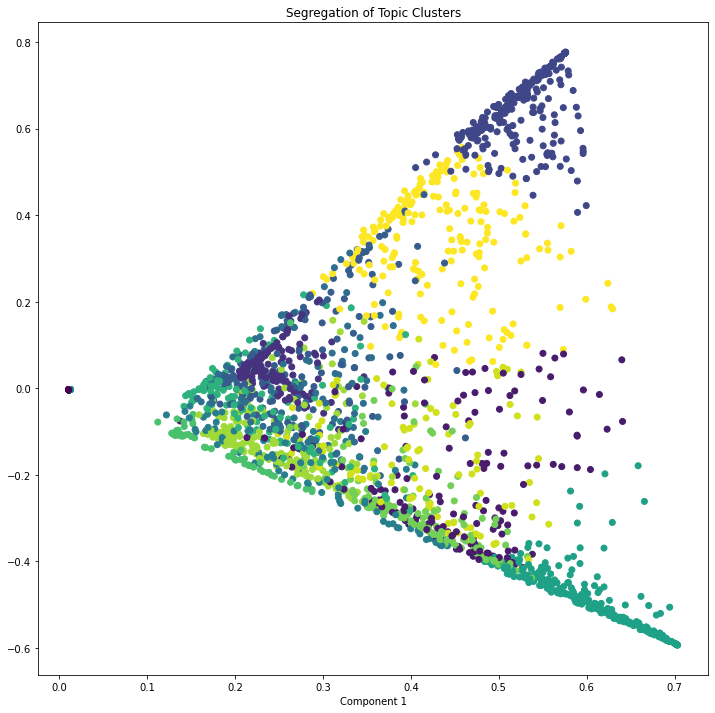

In [ ]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
nlp = spacy.load('en', disable=['parser', 'ner'])
def similar_documents(text, doc_topic_probs, documents = data_list, nlp=nlp, top_n=5, verbose=False):
    infer_topic, topic, topic_probability_scores  = predict_topic(text)
    x=topic_probability_scores
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [ ]:
mytext = ["Earthquake alert: Seismic expert says megaquake could hit this place today"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data_list, top_n=5, verbose=True)
print(doc_ids)
print(docs)


Topic KeyWords:  ['police', 'farmer', 'protest', 'people', 'area', 'law', 'tractor', 'violence', 'report', 'border', 'government', 'late', 'district']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.9]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.9]
 [0.  0.1 0.  0.  0.  0.  0.1 0.  0.  0.9]
 [0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.9]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.9]]
[ 98 111  35 175 454]
['Tractor Rally: Over 300 personnel were injured in Tuesday\'s violence (File) A farmer from Uttar Pradesh who died in Delhi\'s ITO area while participating in Tuesday\'s tractor rally that descended into violence and chaos, was not shot as claimed by some of his fellow protesters yesterday, the UP police said today. The 26-year-old man\'s post-mortem examination has confirmed that he died from injuries received in a tractor accident, police added. "The post-mortem report clarifies that he was not shot. He

# NER


In [ ]:
##NER 
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
text="Prime Minister Narendra Modi on Thursday (December 26) morning said he could not see the 'ring of fire' - the solar eclipse or 'Surya grahan' due to cloud cover, but caught glimpses in Kozhikode and other parts on the live stream. Taking to Twitter, PM Modi posted his pictures trying to see the Sun. 'Like many Indians, I was enthusiastic about #solareclipse2019. Unfortunately, I could not see the Sun due to cloud cover but I did catch glimpses of the eclipse in Kozhikode and other parts on live stream. Also enriched my knowledge on the subject by interacting with experts,' tweeted PM Modi. The ring of fire When the Moon will be on the same path between the Earth and the Sun, it will cover the centre of Sun, which will result in a ring of fire. Last solar eclipse of the decade Several parts of India, including Kerala, Karnataka, Tamil Nadu, Gujarat, Odisha, Maharashtra and New Delhi, are witnessing the annual solar eclipse, which is said to the last one for the decade. The solar eclipse began at 7:59 am today morning. The December 26 solar eclipse is what is well known as an 'annular solar eclipse'. Apart from India, Saudi Arabia, Qatar, United Arab Emirates, Oman, Sri Lanka, Malaysia, Indonesia, Singapore, Northern Mariana Islands, and Guam will be able to see the solar eclipse 2019. Dubai witnessed solar eclipse Solar eclipse in Tamil Nadu Solar eclipse visible from Ahmedabad, Gujarat Â Delhi people were disappointed as fog blocked the view of the much-awaited annual solar eclipse today morning. However, people in the southern parts of India were able to watch the rare celestial spectacle. 'Solar eclipse will occur over Karnataka for around three hours from 8.06 a.m. to 11.11 a.m. but its visibility will depend on the weather as the cloudy sky may mar its clear viewing,' Jawaharlal Nehru Planetarium Director Pramod Galgali told news agency IANS."
article=nlp(text)

In [ ]:
labels = [x.label_ for x in article.ents]
Counter(labels)


Counter({'DATE': 7,
         'FAC': 1,
         'GPE': 20,
         'LOC': 5,
         'MONEY': 1,
         'NORP': 1,
         'ORG': 5,
         'PERSON': 8,
         'PRODUCT': 1,
         'TIME': 6})

In [ ]:

people = [ee for ee in article.ents if ee.label_ == 'PERSON']
people

[Narendra Modi,
 Surya grahan',
 Sun,
 Moon,
 Tamil Nadu,
 Tamil Nadu Solar,
 Karnataka,
 Pramod Galgali]

In [ ]:
from spacy.tokens import Span
import dateparser

def expand_person_entities(doc):
    new_ents = []
    for ent in doc.ents:
        # Only check for title if it's a person and not the first token
        if ent.label_ == "PERSON":
            if ent.start != 0:
                # if person preceded by title, include title in entity
                prev_token = doc[ent.start - 1]
                if prev_token.text in ("Dr", "Dr.", "Mr", "Mr.", "Ms", "Ms."):
                    new_ent = Span(doc, ent.start - 1, ent.end, label=ent.label)
                    new_ents.append(new_ent)
                else:
                    # if entity can be parsed as a date, it's not a person
                    if dateparser.parse(ent.text) is None:
                        new_ents.append(ent) 
        else:
            new_ents.append(ent)
    doc.ents = new_ents
    return doc

In [ ]:
doc="Prime Minister Narendra Modi on Thursday (December 26) morning said he could not see the 'ring of fire' - the solar eclipse or 'Surya grahan' due to cloud cover, but caught glimpses in Kozhikode and other parts on the live stream. Taking to Twitter, PM Modi posted his pictures trying to see the Sun. 'Like many Indians, I was enthusiastic about #solareclipse2019. Unfortunately, I could not see the Sun due to cloud cover but I did catch glimpses of the eclipse in Kozhikode and other parts on live stream. Also enriched my knowledge on the subject by interacting with experts,' tweeted PM Modi. The ring of fire When the Moon will be on the same path between the Earth and the Sun, it will cover the centre of Sun, which will result in a ring of fire. Last solar eclipse of the decade Several parts of India, including Kerala, Karnataka, Tamil Nadu, Gujarat, Odisha, Maharashtra and New Delhi, are witnessing the annual solar eclipse, which is said to the last one for the decade. The solar eclipse began at 7:59 am today morning. The December 26 solar eclipse is what is well known as an 'annular solar eclipse'. Apart from India, Saudi Arabia, Qatar, United Arab Emirates, Oman, Sri Lanka, Malaysia, Indonesia, Singapore, Northern Mariana Islands, and Guam will be able to see the solar eclipse 2019. Dubai witnessed solar eclipse Solar eclipse in Tamil Nadu Solar eclipse visible from Ahmedabad, Gujarat Â Delhi people were disappointed as fog blocked the view of the much-awaited annual solar eclipse today morning. However, people in the southern parts of India were able to watch the rare celestial spectacle. 'Solar eclipse will occur over Karnataka for around three hours from 8.06 a.m. to 11.11 a.m. but its visibility will depend on the weather as the cloudy sky may mar its clear viewing,' Jawaharlal Nehru Planetarium Director Pramod Galgali told news agency IANS."

document_string=expand_person_entities(doc)

AttributeError: ignored

In [ ]:
# Add the component after the named entity recognizer
# nlp.remove_pipe('expand_person_entities')


doc = nlp(document_string)
[(ent.text, ent.label_) for ent in doc.ents if ent.label_=='PERSON']

TypeError: ignored